# DACON - 주차수요 예측 AI 경진대회
### 주제: 유형 별 임대주택 설계 시 단지 내 적정 주차 수요 예측
평가 방식: MAE (Mean Absolute Error)

target: 등록차량수

## 라이브러리 불러오기

In [ ]:
!pip install pycaret
!pip install shap

In [ ]:
# 한글 폰트 깨짐 현상 해결 위함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pycaret.regression import *
import os
plt.rc('font', family='NanumBarunGothic') # 한글 폰트 설정
from google.colab import drive 
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 파일 불러오기

In [2]:
path = os.path.join("/content", "gdrive", "MyDrive", "data")

In [3]:
train = pd.read_csv(path + "/train.csv")
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [4]:
test = pd.read_csv(path + "/test.csv")
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [5]:
ag = pd.read_csv(path + "/age_gender_info.csv")
ag.set_index('지역', inplace=True)
ag.head()

,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [6]:
car = pd.read_excel(path+'/2020년_12월_자동차_등록자료_통계.xlsx', skiprows=[0,1,2])
car.drop('Unnamed: 1', axis=1, inplace=True)
car.drop(0, axis=0, inplace=True)
car.rename(columns={'자가용': '승용_자가용', '자가용.1' : '승합_자가용', '용도별' : '지역'}, inplace=True)
car.dropna(subset=['지역'], inplace=True)
car.set_index('지역', inplace=True)
car.head()

,관용,승용_자가용,영업용,계,관용.1,승합_자가용,영업용.1,계.1,관용.2,자가용.2,영업용.2,계.2,관용.3,자가용.3,영업용.3,계.3,관용.4,자가용.4,영업용.4,계.4
지역,,,,,,,,,,,,,,,,,,,,
서울,4607.0,2582001.0,125376.0,2711984.0,3805.0,87315.0,15384.0,106504.0,3937.0,267951.0,58055.0,329943.0,374.0,3625.0,4931.0,8930.0,12723.0,2940892.0,203746.0,3157361.0
부산,1671.0,1103130.0,84544.0,1189345.0,1261.0,34631.0,6164.0,42056.0,1588.0,151295.0,33767.0,186650.0,138.0,1961.0,8890.0,10989.0,4658.0,1291017.0,133365.0,1429040.0
대구,1002.0,1000105.0,25968.0,1027075.0,893.0,25605.0,4003.0,30501.0,1365.0,137478.0,19136.0,157979.0,122.0,1486.0,2033.0,3641.0,3382.0,1164674.0,51140.0,1219196.0
인천,1569.0,1115094.0,309540.0,1426203.0,1048.0,36779.0,11512.0,49339.0,1311.0,160596.0,31354.0,193261.0,120.0,2223.0,5296.0,7639.0,4048.0,1314692.0,357702.0,1676442.0
광주,829.0,561016.0,14521.0,576366.0,597.0,16934.0,2409.0,19940.0,711.0,78289.0,13444.0,92444.0,80.0,1084.0,1826.0,2990.0,2217.0,657323.0,32200.0,691740.0


In [7]:
pop = pd.read_csv(path + '/202012_202012_주민등록인구및세대현황_연간.csv', encoding='EUC-KR')
pop.head()

,행정구역,2020년_총인구수,2020년_세대수,2020년_세대당 인구,2020년_남자 인구수,2020년_여자 인구수,2020년_남여 비율
0,전국 (1000000000),"51,829,023","23,093,108",2.24,"25,841,029","25,987,994",0.99
1,서울특별시 (1100000000),"9,668,465","4,417,954",2.19,"4,701,723","4,966,742",0.95
2,부산광역시 (2600000000),"3,391,946","1,530,431",2.22,"1,661,000","1,730,946",0.96
3,대구광역시 (2700000000),"2,418,346","1,056,627",2.29,"1,193,109","1,225,237",0.97
4,인천광역시 (2800000000),"2,942,828","1,267,956",2.32,"1,473,943","1,468,885",1.00


## 변수 변경(EDA 전)

In [8]:
# 길이가 긴 변수명 변경
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철', '도보 10분거리 내 버스정류장 수': '버스'}, inplace=True)
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철', '도보 10분거리 내 버스정류장 수': '버스'}, inplace=True)

In [9]:
# 전용면적 -> 5단위로 변경
train['전용면적'] = round(train['전용면적'] / 5, 0)
test['전용면적'] = round(test['전용면적'] / 5, 0)

In [10]:
# 임대보증금, 임대료 float으로 형변환
train.loc[train['임대보증금'] == '-', '임대보증금'] = np.nan
test.loc[test['임대보증금'] == '-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train['임대료'] == '-', '임대료'] = np.nan
test.loc[test['임대료'] == '-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [11]:
# age_gender_info 와 train data left outer join
train_merge = pd.merge(left=train, right=ag, how='left', on='지역')
train_merge.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C2483,900,아파트,경상북도,국민임대,8.0,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,C2483,900,아파트,경상북도,국민임대,8.0,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
2,C2483,900,아파트,경상북도,국민임대,10.0,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
3,C2483,900,아파트,경상북도,국민임대,10.0,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
4,C2483,900,아파트,경상북도,국민임대,10.0,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014


## 오류 데이터 처리

DACON 측에서 공지한 오류 데이터 처리<br/>
https://dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

1번 오류는 총 세대수와 전용 면적 별 세대수 합계의 차이가 큰 경우 큰 수로 대체함. <br/>
발생 원인이 '분양' 아파트 / 상가의 혼합인데, 임대/분양 유형에 관계 없이 전체 세대수에 대해서 주차면수가 추정되어야 한다고 생각. <br/>
2, 3번 오류는 주최 측에서 문제가 된 단지 코드에 대한 데이터를 삭제하는 것을 권장하였으므로 삭제함.

In [12]:
# 전용면적 별 세대수 합
train_sum = train[['전용면적별세대수', '단지코드']].groupby(by='단지코드').sum()
test_sum = test[['전용면적별세대수', '단지코드']].groupby(by='단지코드').sum()

In [13]:
# 총세대수를 단지코드 별로 묶기 위함
train_av = train[['총세대수', '단지코드']].groupby(by='단지코드').mean()
test_av = test[['총세대수', '단지코드']].groupby(by='단지코드').mean()

In [14]:
# 1번에서 전용면적별 세대수 합이 총세대수보다 큰 경우가 있는지 확인 
comp_tr = [i for i in train_sum.index if train_sum['전용면적별세대수'][i] > train_av['총세대수'][i]]
comp_te = [i for i in test_sum.index if test_sum['전용면적별세대수'][i] > test_av['총세대수'][i]]
len(comp_tr), len(comp_te)

(0, 0)

총세대수가 전용면적별 세대수의 합보다 크므로, 총세대수는 그대로 유지하고 모델 구축 시 전용면적별 세대수는 사용하지 않을 예정

In [15]:
# 2, 3번에서 문제가 된 단지코드 삭제
train.drop(train.loc[train['단지코드'].isin(['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
# test.drop(test.loc[test['단지코드'].isin(['C2675', 'C2335', 'C1327'])].index, axis=0, inplace=True)

test 평가에서 오류가 있는 데이터를 제외한다고 하였지만, 제외하고 제출한 결과 점수가 더 높게 나와서 포함하고 학습시킴

In [16]:
train.shape, test.shape

((2869, 15), (1022, 14))

## 외부데이터 추가

In [17]:
cars = car[['승용_자가용', '승합_자가용']].copy()
cars['자가용 합계'] = cars['승용_자가용'] + cars['승합_자가용']
cars.rename(index={'서울': '서울특별시', '부산':'부산광역시', '대구':'대구광역시', '인천':'인천광역시', '광주':'광주광역시', '대전':'대전광역시',   
                   '울산':'울산광역시', '세종':'세종특별자치시', '경기':'경기도', '강원':'강원도', '충북':'충청북도', '충남':'충청남도', 
                   '전북':'전라북도', '전남':'전라남도', '경북':'경상북도', '경남':'경상남도', '제주':'제주특별자치도'}, inplace=True)
cars.drop(['합계', '월간증감', '년간증감'], axis=0, inplace=True)
cars.drop(['승용_자가용', '승합_자가용'], axis=1, inplace=True)
cars.head()

,자가용 합계
지역,
서울특별시,2669316.0
부산광역시,1137761.0
대구광역시,1025710.0
인천광역시,1151873.0
광주광역시,577950.0


In [18]:
pops = pop[['행정구역', '2020년_세대수']].copy()
pops.rename( columns={'행정구역':'지역','2020년_세대수':'세대수'}, inplace=True)
pops.set_index('지역', inplace=True)
pops.index = pops.index.str.replace(r'[^가-힣]', '')
pops.drop('전국', axis=0, inplace=True)
pops.head()

,세대수
지역,
서울특별시,"4,417,954"
부산광역시,"1,530,431"
대구광역시,"1,056,627"
인천광역시,"1,267,956"
광주광역시,"633,582"


## EDA

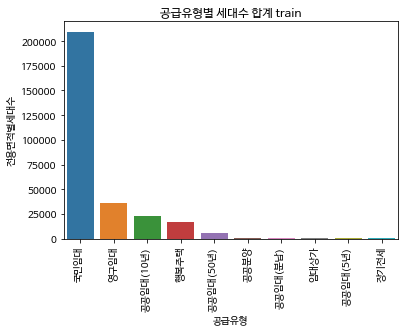

In [19]:
sns.barplot(data=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계 train')
plt.show()

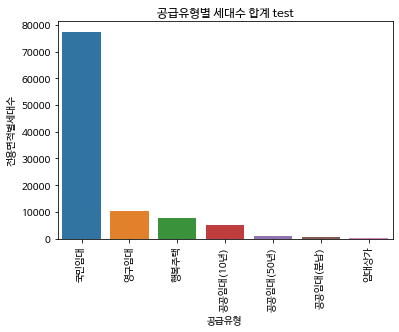

In [20]:
sns.barplot(data=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계 test')
plt.show()

국민임대가 매우 높은 비율을 차지하고 있음

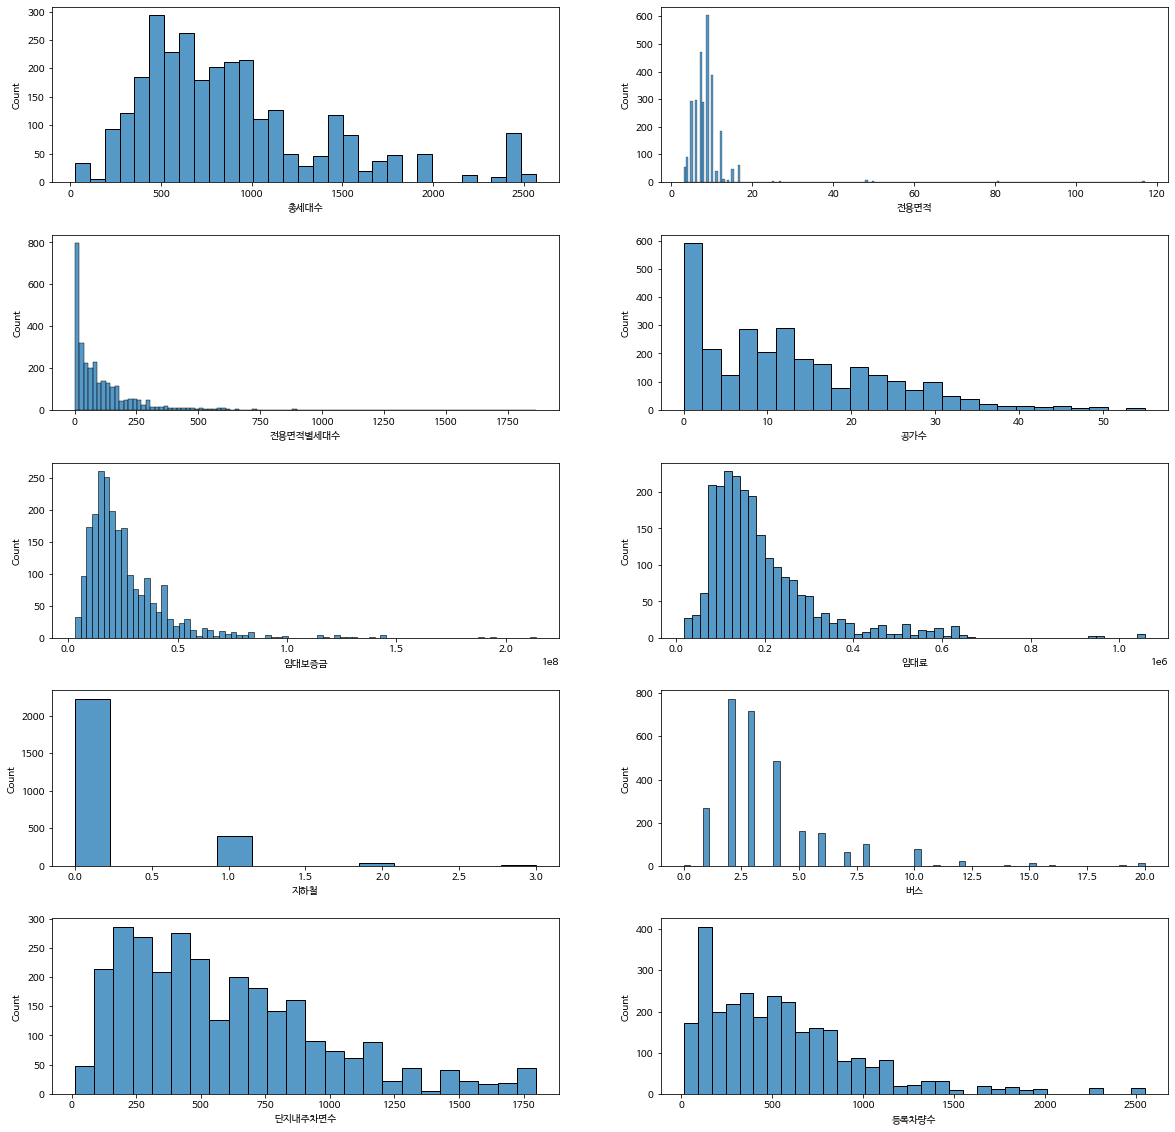

In [21]:
numeric_cols = []
for col in train.columns:
    if train[col].dtypes != 'object':
        numeric_cols.append(col)

fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])

전체적으로 skew된 형태를 띄고 있음

In [22]:
# 전체 평균
ag.loc['전체평균'] = ag.mean()
# 광역시 평균
ag.loc['광역시평균'] = ag.loc[(ag.index.str.contains('시')) & (~ag.index.str.contains('세종'))].mean() # 세종시는 광역시가 아니므로 제외
# 수도권 평균
ag.loc['수도권평균'] = ag.loc[['서울특별시', '경기도']].mean()
# 도 평균
ag.loc['도평균'] = ag.loc[ag.index.str.contains('도')].mean()

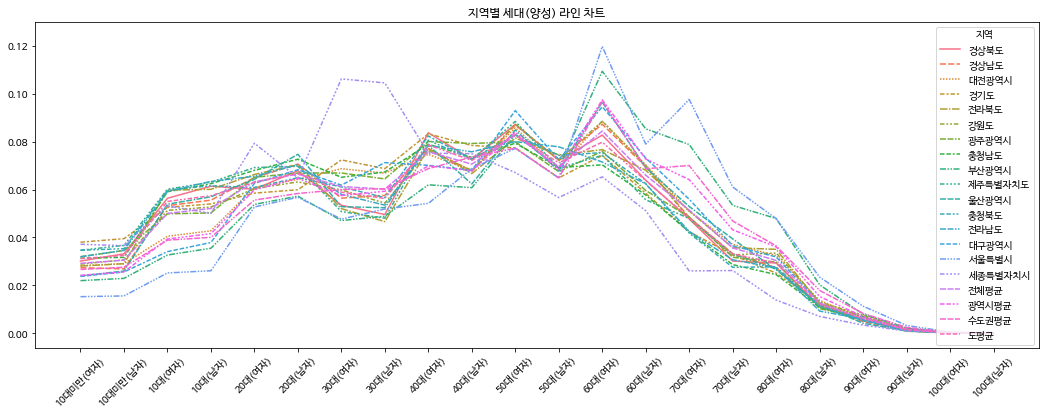

In [23]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.T, )
plt.title('지역별 세대(양성) 라인 차트')
plt.xticks(rotation=45)
plt.ylim(top=0.13)
plt.show()

- 같은 나이대에서 성별에 따른 편차 존재. 대체로 여성이 더 높은 비율을 보임
- 서울, 부산: 60대 여성에서 피크, 서울: 70대 여성에서도 피크
- 세종: 30대에서 높은 비율

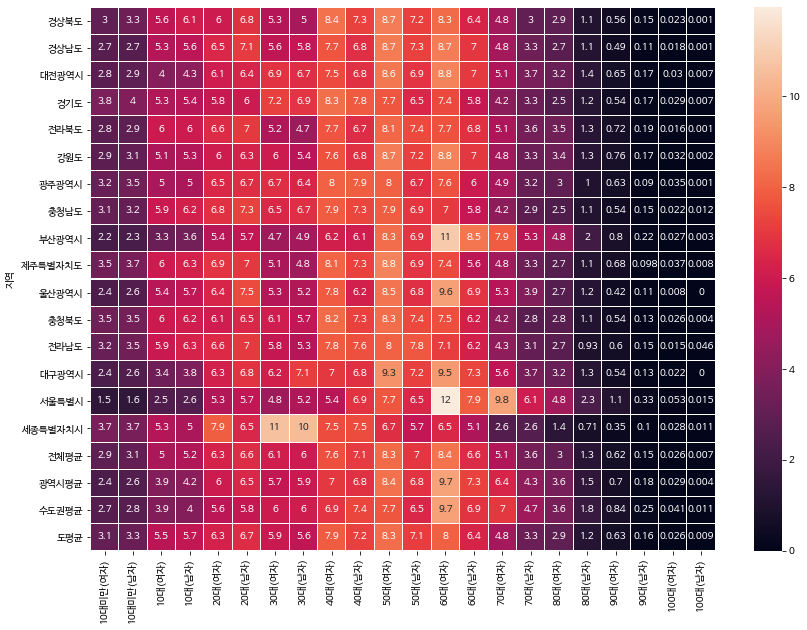

In [24]:
# 데이터를 퍼센트로 바꾸어 heatmap으로 나타냄
plt.figure(figsize=(14, 10))
sns.heatmap((ag*100).round(3),
           annot=True, linewidths=0.01,)

plt.show()

- 인구가 많은 특별시, 광역시, 수도권에서 60, 70대의 비중이 높다
- 세종시는 20, 30대 청년층의 비중이 높다

## 결측치 처리

In [25]:
train.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       581
임대료         584
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [26]:
test.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       186
임대료         186
지하철          42
버스            0
단지내주차면수       0
dtype: int64

In [27]:
test.loc[(pd.isna(test['자격유형']) == True)]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,9.0,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,5.0,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


In [28]:
test.loc[test['단지코드'] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,8.0,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,8.0,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,8.0,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,9.0,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,10.0,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [29]:
# 같은 단지코드에서 임대건물 구분, 공급유형이 같은 경우 같은 자격유형으로 매핑
test.loc[(test['단지코드']=='C2411') & test['자격유형'].isnull(), '자격유형'] = 'A'
test.loc[(test['단지코드']=='C2253') & test['자격유형'].isnull(), '자격유형'] = 'C'

In [30]:
# 지하철, 버스의 결측치는 0으로 대체
train.loc[train['지하철'].isnull(), '지하철'] = 0
train.loc[train['버스'].isnull(), '버스'] = 0
test.loc[test['지하철'].isnull(), '지하철'] = 0

In [31]:
train[train['임대보증금'].isnull()].공급유형.value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

In [32]:
# 임대상가는 임대보증금, 임대료에 대한 정보가 아예 없으므로 0으로 대체
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '임대상가'), '임대보증금'] = 0
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '임대상가'), '임대료'] = 0

In [33]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,5.0,472,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,5.0,104,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,5.0,590,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,8.0,464,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,9.0,304,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2906,C2186,924,아파트,대구광역시,국민임대,6.0,238,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2907,C2186,924,아파트,대구광역시,국민임대,6.0,38,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2908,C2186,924,아파트,대구광역시,국민임대,7.0,220,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0


In [34]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 (평균) 단위면적당가 * 전용면적으로 결측치 처리
train_ = train.loc[(train['지역'] == '부산광역시') & (train['공급유형'] == '국민임대')]
train_['단위당임대보증금'] = train_['임대보증금'] / train_['전용면적']
train_['단위당임대료'] = train_['임대료'] / train_['전용면적']
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '임대보증금'] = train_['단위당임대보증금'].mean() * train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '전용면적']
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '임대료'] = train_['단위당임대료'].mean() * train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '전용면적']

In [35]:
train.loc[(train['단지코드'] == 'C2186') & (train['공급유형'] == '국민임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2906,C2186,924,아파트,대구광역시,국민임대,6.0,238,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2907,C2186,924,아파트,대구광역시,국민임대,6.0,38,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2908,C2186,924,아파트,대구광역시,국민임대,7.0,220,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2909,C2186,924,아파트,대구광역시,국민임대,9.0,188,0.0,H,25981000.0,248630.0,0.0,8.0,664.0,744.0


In [36]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 단위면적당가 * 전용면적 으로 결측치 처리
deposit = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '임대보증금'].values[0]
size = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적'].values[0]
train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '임대보증금'] = (deposit / size) * train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적']
rent = train.loc[(~train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '임대료'].values[0]
train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '임대료'] = (rent / size) * train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적']

In [37]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '공공분양')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,15.0,317,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,15.0,137,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,15.0,22,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,17.0,164,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,17.0,19,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,17.0,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,17.0,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0


In [38]:
# 공공분양은 임대보증금, 임대료가 없으므로 0으로 대체
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '공공분양'), '임대보증금'] = 0
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '공공분양'), '임대료'] = 0

In [39]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '행복주택')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2680,C1786,480,아파트,강원도,행복주택,3.0,156,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,5.0,136,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,5.0,72,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,5.0,24,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0


In [40]:
train.loc[(train['공급유형'] == '행복주택') & (train['지역'] =='강원도')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2680,C1786,480,아파트,강원도,행복주택,3.0,156,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,5.0,136,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,5.0,72,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,5.0,24,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2684,C1786,480,아파트,강원도,행복주택,7.0,92,25.0,J,30560000.0,145160.0,0.0,3.0,338.0,345.0


In [41]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 단위면적당가 * 전용면적으로 결측치 처리
deposit = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '임대보증금'].values[0]
size = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적'].values[0]
train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '임대보증금'] = (deposit / size) * train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적']

In [42]:
rent = train.loc[(~train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '임대료'].values[0]
train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '임대료'] = (deposit / size) * train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적']

In [43]:
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '장기전세'), '임대료'] = 0

In [44]:
test[test['임대보증금'].isnull()].공급유형.value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [45]:
# 임대상가는 임대보증금, 임대료에 대한 정보가 아예 없으므로 0으로 대체
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '임대상가'), '임대보증금'] = 0
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '임대상가'), '임대료'] = 0

In [46]:
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,5.0,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,5.0,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,11.0,6,27.0,D,NaN,NaN,2.0,5.0,428.0
1005,C2152,120,아파트,강원도,영구임대,5.0,66,9.0,C,NaN,NaN,0.0,1.0,40.0
1006,C2152,120,아파트,강원도,영구임대,7.0,54,9.0,C,NaN,NaN,0.0,1.0,40.0


In [47]:
# train 데이터에서 아파트 - 자격유형 D는 공공분양 -> 임대보증금, 임대료 0이었으므로 정보가 없으므로 0으로 처리
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['단지코드'] == 'C1006'), '임대보증금'] = 0
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['단지코드'] == 'C1006'), '임대료'] = 0

In [48]:
test.loc[(test['공급유형'] == '영구임대') & (test['지역'] == '강원도') & (test['자격유형'] == 'C')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,5.0,745,0.0,C,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,6.0,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,6.0,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
308,C1729,627,아파트,강원도,영구임대,7.0,180,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
309,C1729,627,아파트,강원도,영구임대,7.0,64,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
310,C1729,627,아파트,강원도,영구임대,7.0,27,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
311,C1729,627,아파트,강원도,영구임대,7.0,44,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
312,C1729,627,아파트,강원도,영구임대,8.0,180,0.0,C,6496000.0,120600.0,0.0,5.0,131.0
313,C1729,627,아파트,강원도,영구임대,8.0,56,0.0,C,6496000.0,120600.0,0.0,5.0,131.0
314,C1729,627,아파트,강원도,영구임대,8.0,23,0.0,C,6496000.0,120600.0,0.0,5.0,131.0


In [49]:
test_ = test.loc[(test['공급유형'] == '영구임대') & (test['지역'] == '강원도') & (test['자격유형'] == 'C')]
test_['단위당임대보증금'] = test_['임대보증금'] / test_['전용면적']
test_['단위당임대료'] = test_['임대료'] / test_['전용면적']
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '임대보증금'] = test_['단위당임대보증금'].mean() * test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '전용면적']
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '임대료'] = test_['단위당임대료'].mean() * test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '전용면적']

In [50]:
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
1014,C1267,675,아파트,경상남도,행복주택,3.0,50,38.0,L,NaN,NaN,0.0,1.0,467.0
1015,C1267,675,아파트,경상남도,행복주택,5.0,66,38.0,L,NaN,NaN,0.0,1.0,467.0
1016,C1267,675,아파트,경상남도,행복주택,5.0,8,38.0,L,NaN,NaN,0.0,1.0,467.0
1017,C1267,675,아파트,경상남도,행복주택,7.0,126,38.0,L,NaN,NaN,0.0,1.0,467.0


In [51]:
test.loc[(test['공급유형'] == '행복주택') & (test['지역'] =='경상남도')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
854,C1003,480,아파트,경상남도,행복주택,3.0,128,29.0,J,12000000.0,61000.0,0.0,3.0,339.0
855,C1003,480,아파트,경상남도,행복주택,5.0,172,29.0,J,19600000.0,100000.0,0.0,3.0,339.0
856,C1003,480,아파트,경상남도,행복주택,5.0,48,29.0,J,19600000.0,100000.0,0.0,3.0,339.0
857,C1003,480,아파트,경상남도,행복주택,5.0,30,29.0,J,18800000.0,96000.0,0.0,3.0,339.0
858,C1003,480,아파트,경상남도,행복주택,7.0,56,29.0,J,25600000.0,131000.0,0.0,3.0,339.0
859,C1003,480,아파트,경상남도,행복주택,7.0,12,29.0,J,25600000.0,131000.0,0.0,3.0,339.0
860,C1003,480,아파트,경상남도,행복주택,9.0,28,29.0,J,30000000.0,154000.0,0.0,3.0,339.0
861,C1003,480,아파트,경상남도,행복주택,9.0,6,29.0,J,30000000.0,154000.0,0.0,3.0,339.0
862,C2268,900,아파트,경상남도,행복주택,3.0,80,45.0,K,33446000.0,17420.0,0.0,2.0,633.0
863,C2268,900,아파트,경상남도,행복주택,3.0,324,45.0,K,33446000.0,17420.0,0.0,2.0,633.0


In [52]:
test_ = test.loc[(test['공급유형'] == '행복주택') & (test['지역'] == '경상남도')]
test_['단위당임대보증금'] = test_['임대보증금'] / test_['전용면적']
test_['단위당임대료'] = test_['임대료'] / test_['전용면적']
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '임대보증금'] = test_['단위당임대보증금'].mean() * test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '전용면적']
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '임대료'] = test_['단위당임대료'].mean() * test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '전용면적']

In [53]:
train.isna().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
등록차량수       0
dtype: int64

In [54]:
test.isna().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
dtype: int64

## 이상치 처리

In [55]:
pd.concat([train['공급유형'].value_counts(), 
           test['공급유형'].value_counts()], axis=1)

,공급유형,공급유형
국민임대,1727,622.0
임대상가,562,177.0
행복주택,202,124.0
공공임대(10년),175,35.0
영구임대,152,45.0
공공임대(50년),31,13.0
공공분양,7,NaN
공공임대(분납),7,6.0
공공임대(5년),3,NaN
장기전세,3,NaN


test set에는 장기전세, 공공분양, 공공임대(5년)에 대한 정보가 없다. <br/>
장기전세, 공공분양은 train set에서 제외한다.(공공임대(5년)은 다른 공공임대 유형과 묶을 예정이므로 우선 살려둔다.)

In [56]:
train.drop(train.loc[(train['공급유형']=='장기전세') | (train['공급유형'] == '공공분양')].index, axis=0, inplace=True)

## 변수 변경(EDA 후)

In [57]:
# 공공임대 하나로 묶기
train.loc[train['공급유형'].isin(['공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '공공임대(5년)']), '공급유형'] = '공공임대'
test.loc[test['공급유형'].isin(['공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '공공임대(5년)']), '공급유형'] = '공공임대'

In [58]:
# 하나의 단지코드에 하나의 값만 존재하는 변수들을 따로 모음
unique_cols = ['총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [59]:
train_agg['대중교통'] = train_agg['지하철'] + train_agg['버스']
test_agg['대중교통'] = test_agg['지하철'] + test_agg['버스']

In [60]:
train_agg.drop(['지하철', '버스'], axis=1, inplace=True)
test_agg.drop(['지하철', '버스'], axis=1, inplace=True)

In [61]:
# 하나의 단지코드에 복수의 값이 존재하는 변수들 처리
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [62]:
reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter')

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1003,0.0,1.0
C1006,1.0,1.0
C1016,0.0,1.0
C1019,0.0,1.0
C1030,0.0,1.0
C1038,0.0,1.0
C1040,0.0,1.0
C1060,0.0,1.0
C1064,0.0,1.0


In [63]:
reshape_cat_features(data=train, cast_col='공급유형', value_col='counter')

,공급유형_공공임대,공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택
단지코드,,,,,
C1000,0.0,1.0,0.0,0.0,0.0
C1004,0.0,0.0,1.0,1.0,0.0
C1005,0.0,1.0,0.0,0.0,0.0
C1013,0.0,1.0,0.0,0.0,0.0
C1014,0.0,1.0,0.0,0.0,0.0
C1015,0.0,1.0,0.0,0.0,0.0
C1017,0.0,1.0,0.0,0.0,0.0
C1022,0.0,1.0,0.0,0.0,0.0
C1024,1.0,0.0,0.0,0.0,0.0


In [64]:
train_agg = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter')
                      ], axis=1)

test_agg = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter')
                     ], axis=1)

In [65]:
train_agg.shape, test_agg.shape

((411, 13), (150, 12))

In [66]:
rate = pd.merge(left=pops, right=cars, how='inner', on='지역')
rate['세대수'] = rate['세대수'].str.replace(r'[^0-9]', '')
rate['세대수'] = rate['세대수'].astype('float')
rate['세대당자동차보유율'] = rate['자가용 합계'] / rate['세대수']
rate.head()

,세대수,자가용 합계,세대당자동차보유율
지역,,,
서울특별시,4417954.0,2669316.0,0.604197
부산광역시,1530431.0,1137761.0,0.743425
대구광역시,1056627.0,1025710.0,0.970740
인천광역시,1267956.0,1151873.0,0.908449
광주광역시,633582.0,577950.0,0.912194


In [67]:
rates = rate[['세대당자동차보유율']].copy()
rates.head()

,세대당자동차보유율
지역,
서울특별시,0.604197
부산광역시,0.743425
대구광역시,0.970740
인천광역시,0.908449
광주광역시,0.912194


In [68]:
train_merge = pd.merge(left=train_agg, right=ag, how='left', on='지역')
test_merge = pd.merge(left=test_agg, right=ag, how='left', on='지역')

In [69]:
train_merge = pd.merge(left=train_merge, right=rates, how='left', on='지역')
test_merge = pd.merge(left=test_merge, right=rates, how='left', on='지역')

In [70]:
train_merge['단지당자동차보유수'] = train_merge['세대당자동차보유율'] * train_merge['총세대수']
test_merge['단지당자동차보유수'] = test_merge['세대당자동차보유율'] * test_merge['총세대수']
train_merge.drop('세대당자동차보유율', axis=1, inplace=True)
test_merge.drop('세대당자동차보유율', axis=1, inplace=True)

In [71]:
train_merge.set_index(train_agg.index, inplace=True)
test_merge.set_index(test_agg.index, inplace=True)

In [72]:
train_merge['지역'] = train_merge['지역'].astype('category')
test_merge['지역'] = test_merge['지역'].astype('category')

## 데이터 분리 / 변수선택

상가가 있을 때 총세대수와 단지내주차면수의 차이가 크기 때문에, 분리해서 모델 학습을 진행

In [73]:
train_has_store = train_merge.loc[train_merge['공급유형_임대상가'] == 1]
train_apt_only = train_merge.loc[train_merge['공급유형_임대상가'] == 0]

test_has_store = test_merge.loc[test_merge['공급유형_임대상가'] == 1]
test_apt_only = test_merge.loc[test_merge['공급유형_임대상가'] == 0]

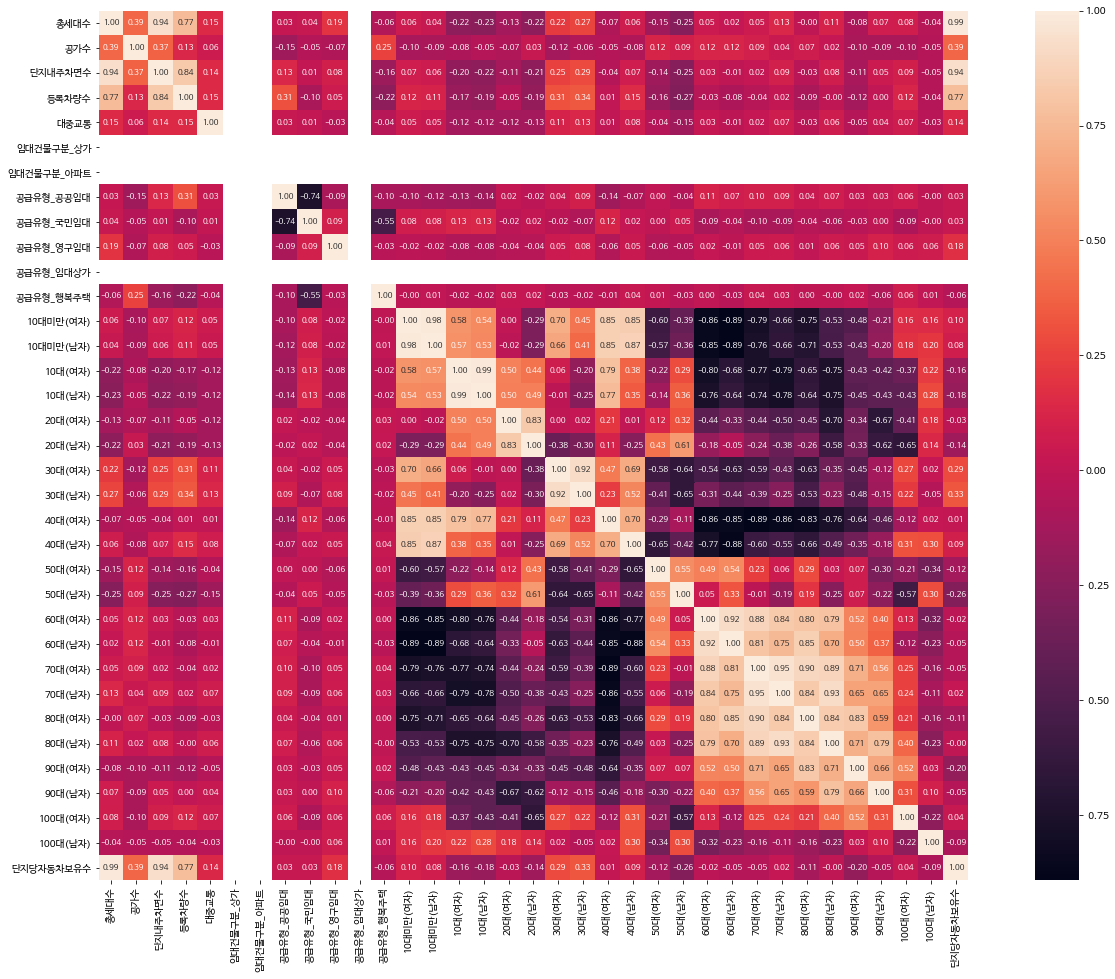

In [74]:
corr = train_apt_only.corr()
f, ax = plt.subplots(figsize = (24, 16))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', annot_kws={'size':8})

In [75]:
select_var1 = [i for i in corr['등록차량수'].index if (1>corr['등록차량수'][i] > 0.3 or corr['등록차량수'][i] < -0.3)]
select_var1

['총세대수', '단지내주차면수', '공급유형_공공임대', '30대(여자)', '30대(남자)', '단지당자동차보유수']

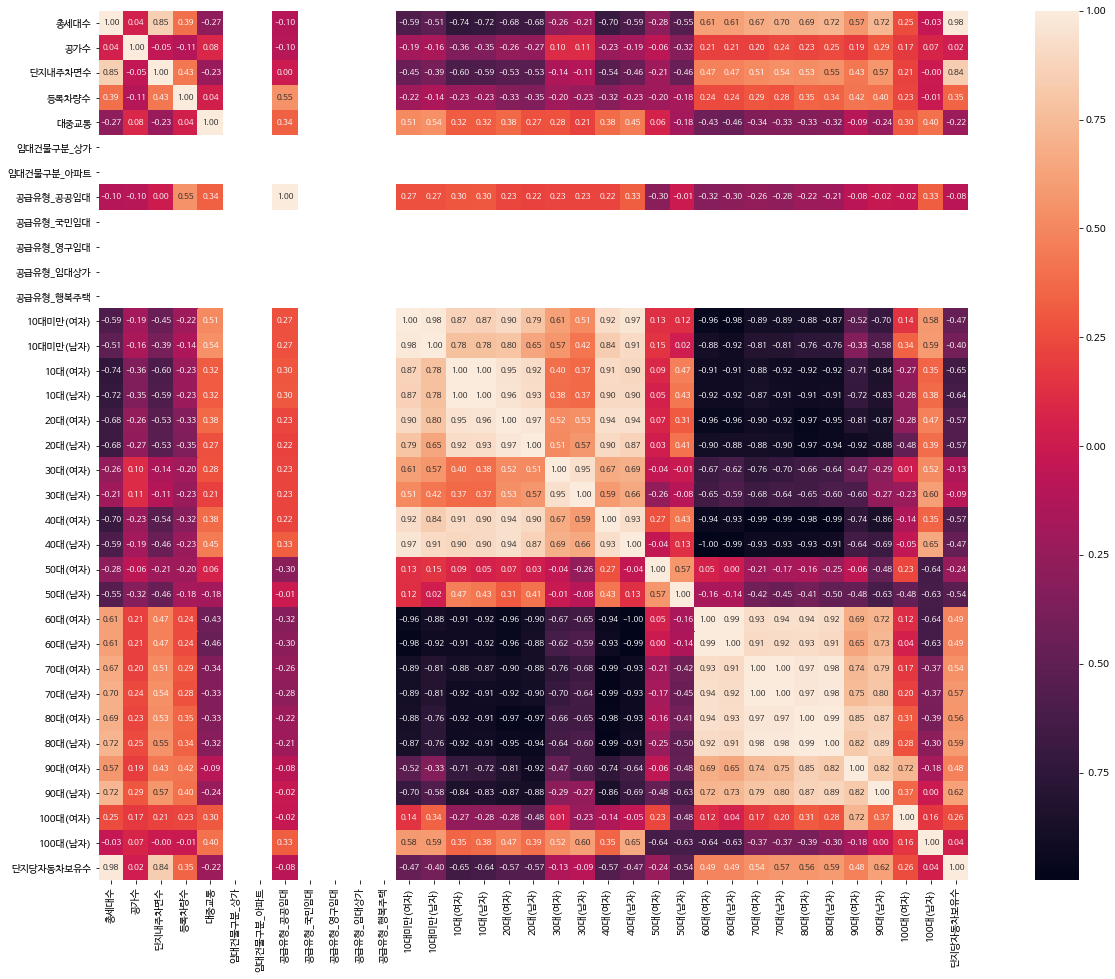

In [76]:
corr = train_has_store.corr()
f, ax = plt.subplots(figsize = (24, 16))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', annot_kws={'size':8})

In [77]:
select_var2 = [i for i in corr['등록차량수'].index if (1>corr['등록차량수'][i] > 0.3 or corr['등록차량수'][i] < -0.3)]
select_var2

['총세대수',
 '단지내주차면수',
 '공급유형_공공임대',
 '20대(여자)',
 '20대(남자)',
 '40대(여자)',
 '80대(여자)',
 '80대(남자)',
 '90대(여자)',
 '90대(남자)',
 '단지당자동차보유수']

In [78]:
test_has_store = test_has_store[select_var2]
test_apt_only = test_apt_only[select_var1]

select_var2.append('등록차량수')
select_var1.append('등록차량수')
train_has_store = train_has_store[select_var2]
train_apt_only = train_apt_only[select_var1]

## 모델 학습

### 상가 있는 경우

In [79]:
categorical_features = ['공급유형_공공임대', '공급유형_임대상가', '공급유형_영구임대', '공급유형_국민임대', '공급유형_행복주택', '임대건물구분_아파트', '임대건물구분_상가']

In [80]:
reg1 = setup(train_has_store, target='등록차량수', session_id=123)

,Description,Value
0,session_id,123
1,Target,등록차량수
2,Original Data,"(33, 12)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(23, 11)"


In [81]:
best_model = compare_models(fold=5,sort='MAE', n_select=4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,6.778510e+01,1.706908e+04,9.792080e+01,-3.887300e+00,0.4772,0.3654,0.080
gbr,Gradient Boosting Regressor,6.853290e+01,1.826155e+04,1.027094e+02,-3.387700e+00,0.4938,0.3256,0.044
dt,Decision Tree Regressor,7.032000e+01,1.745916e+04,1.022408e+02,-6.688600e+00,0.5109,0.3742,0.018
rf,Random Forest Regressor,7.337180e+01,1.779151e+04,1.024100e+02,-3.827100e+00,0.4952,0.3841,0.472
llar,Lasso Least Angle Regression,7.615580e+01,1.774455e+04,1.065712e+02,-3.067400e+00,0.5365,0.4112,0.018
lasso,Lasso Regression,7.668600e+01,1.773305e+04,1.000584e+02,-2.256400e+00,0.5226,0.4276,0.022
knn,K Neighbors Regressor,8.486800e+01,1.965387e+04,1.220566e+02,-2.193030e+01,0.6130,0.5245,0.072
et,Extra Trees Regressor,8.611210e+01,2.208488e+04,1.199919e+02,-2.517300e+00,0.5647,0.4584,0.418
huber,Huber Regressor,8.612840e+01,1.998621e+04,1.144630e+02,-6.697900e+00,0.8410,0.4958,0.036
par,Passive Aggressive Regressor,8.621910e+01,2.130368e+04,1.194923e+02,-1.091160e+01,0.6651,0.6335,0.016


In [82]:
ada = create_model('ada', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,69.3262,11594.1116,107.6760,0.0822,0.5328,0.4120
1,171.0400,68710.9280,262.1277,-0.6480,0.9340,0.5219
2,36.5429,2721.5032,52.1680,0.6841,0.2737,0.2337
3,33.1000,1429.2400,37.8053,0.8825,0.2860,0.2282
4,28.9167,889.6389,29.8268,-20.4371,0.3596,0.4314
Mean,67.7851,17069.0843,97.9208,-3.8873,0.4772,0.3654
SD,53.5795,26111.6358,86.4905,8.2921,0.2464,0.1159


In [85]:
tuned_ada = tune_model(ada, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.9905,11167.3140,105.6755,0.1160,0.5085,0.3537
1,170.9750,68850.2531,262.3933,-0.6514,0.9357,0.5219
2,31.6667,1633.2222,40.4131,0.8104,0.2601,0.2344
3,46.7375,3348.3756,57.8652,0.7247,0.3205,0.2693
4,22.8750,533.5625,23.0990,-11.8569,0.2961,0.3460
Mean,67.2489,17106.5455,97.8892,-2.1714,0.4642,0.3451
SD,53.7133,26138.3262,86.7424,4.8710,0.2509,0.0993


In [83]:
gbr = create_model('gbr', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,66.8775,12004.9357,109.5670,0.0497,0.5243,0.3366
1,178.1324,72857.5176,269.9213,-0.7475,0.9823,0.5532
2,35.4532,3237.0529,56.8951,0.6243,0.3073,0.1829
3,38.1007,2433.6513,49.3321,0.7999,0.3434,0.2103
4,24.1009,774.6019,27.8317,-17.6651,0.3116,0.3453
Mean,68.5329,18261.5519,102.7094,-3.3877,0.4938,0.3256
SD,56.5851,27575.0472,87.8198,7.1591,0.2570,0.1311


In [86]:
tuned_gbr = tune_model(gbr, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,51.6746,5789.2271,76.0870,0.5417,0.4225,0.2778
1,171.5341,67564.1848,259.9311,-0.6205,0.8860,0.5338
2,30.3479,1044.8029,32.3234,0.8787,0.3629,0.3008
3,43.2672,2860.9529,53.4879,0.7648,0.3303,0.2975
4,60.5984,7796.6829,88.2988,-186.8719,0.6532,0.8281
Mean,71.4844,17011.1701,102.0256,-37.0614,0.5310,0.4476
SD,51.0084,25383.4576,81.2523,74.9071,0.2104,0.2122


In [88]:
dt = create_model('dt', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,70.4000,12170.0000,110.3177,0.0366,0.5296,0.3581
1,171.2000,68447.6000,261.6249,-0.6417,0.9290,0.5260
2,36.0000,3369.2000,58.0448,0.6089,0.2806,0.1910
3,37.2500,1844.2500,42.9447,0.8484,0.3863,0.2567
4,36.7500,1464.7500,38.2721,-34.2952,0.4288,0.5394
Mean,70.3200,17459.1600,102.2408,-6.6886,0.5109,0.3742
SD,52.1061,25791.3542,83.7017,13.8129,0.2238,0.1400


In [89]:
tuned_dt = tune_model(dt, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,55.400,11007.8000,104.9181,0.1286,0.4732,0.2284
1,183.800,75271.8000,274.3571,-0.8054,0.9810,0.5741
2,24.400,1114.8000,33.3886,0.8706,0.3206,0.1780
3,47.250,4063.2500,63.7436,0.6659,0.4073,0.2418
4,14.500,731.5000,27.0463,-16.6265,0.2616,0.1886
Mean,65.070,18437.8300,100.6907,-3.1533,0.4887,0.2822
SD,61.187,28654.9665,91.1000,6.7615,0.2565,0.1479


In [84]:
rf = create_model('rf', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.2420,10330.1441,101.6373,0.1823,0.4764,0.3225
1,187.7640,71030.5310,266.5155,-0.7037,0.9615,0.6480
2,35.4480,2266.3100,47.6058,0.7369,0.2826,0.2331
3,56.2125,4459.7098,66.7811,0.6333,0.4261,0.3557
4,25.1925,870.8617,29.5104,-19.9846,0.3296,0.3611
Mean,73.3718,17791.5113,102.4100,-3.8271,0.4952,0.3841
SD,58.7594,26814.7065,85.4617,8.0947,0.2430,0.1397


In [90]:
tuned_rf = tune_model(rf, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,52.6227,7163.0800,84.6350,0.4330,0.3718,0.2766
1,124.1123,61416.6888,247.8239,-0.4731,0.8573,0.2637
2,52.7919,5452.6297,73.8419,0.3671,0.4344,0.3352
3,63.0981,9890.7971,99.4525,0.1868,0.4273,0.2751
4,30.5231,1119.6941,33.4618,-25.9806,0.3696,0.4417
Mean,64.6296,17008.5780,107.8430,-5.0934,0.4921,0.3185
SD,31.5851,22386.0381,73.3380,10.4485,0.1846,0.0665


In [91]:
blender = blend_models(estimator_list = [tuned_dt, tuned_ada, tuned_rf], fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56.0044,9613.5303,98.0486,0.2390,0.4387,0.2699
1,151.1881,65651.5690,256.2256,-0.5746,0.9060,0.3979
2,34.6862,2199.7778,46.9018,0.7447,0.3013,0.2279
3,50.6433,5093.5692,71.3692,0.5812,0.3282,0.2440
4,21.9660,627.4729,25.0494,-14.1198,0.2829,0.3151
Mean,62.8976,16637.1838,99.5189,-2.6259,0.4514,0.2909
SD,45.7475,24697.1506,82.0559,5.7649,0.2336,0.0611


In [92]:
best = automl(optimize='MAE')
best

VotingRegressor(estimators=[('dt',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mae', max_depth=3,
                                                   max_features=1.0,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0002,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=3,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=123,
                                                   splitter='best')),
                            ('ada',
                             AdaBoostRegressor(b

In [93]:
final_model = finalize_model(best)

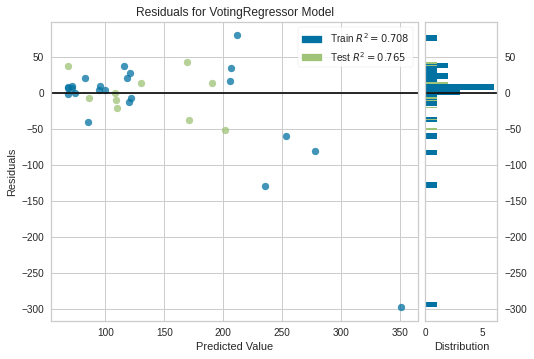

In [94]:
plot_model(final_model)

R^2이 test셋에서 더 크며 0.7 이상이므로 모델의 설명력이 나쁘지 않은 것 같다.

In [95]:
pred_s = predict_model(final_model, data=test_has_store)
pred_s.head()

,총세대수,단지내주차면수,공급유형_공공임대,20대(여자),20대(남자),40대(여자),80대(여자),80대(남자),90대(여자),90대(남자),단지당자동차보유수,Label
C1006,1505,428.0,0.0,0.060834,0.064247,0.074667,0.032455,0.013751,0.006494,0.001740,1336.690600,117.820513
C2676,2572,418.0,0.0,0.053796,0.057233,0.061952,0.047908,0.020228,0.008043,0.002240,1912.089661,269.517735
C2177,1245,187.0,0.0,0.067975,0.072622,0.078860,0.024514,0.010900,0.005429,0.001549,1137.816230,173.475641
C2033,1400,308.0,0.0,0.064240,0.074689,0.078450,0.026540,0.011912,0.004221,0.001087,1439.199988,125.597009
C1812,1021,185.0,0.0,0.064240,0.074689,0.078450,0.026540,0.011912,0.004221,0.001087,1049.587991,151.954843


### 상가 없는 경우

In [97]:
reg2 = setup(train_apt_only, target='등록차량수', session_id=123)

,Description,Value
0,session_id,123
1,Target,등록차량수
2,Original Data,"(378, 7)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(264, 6)"


In [98]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,144.9971,44484.4036,208.2646,0.6962,0.4303,0.4184,0.020
huber,Huber Regressor,146.7232,45271.1678,210.8170,0.6869,0.4197,0.3981,0.042
ridge,Ridge Regression,147.7971,46048.6363,212.5696,0.6828,0.4078,0.3811,0.022
lasso,Lasso Regression,148.0601,46218.1949,212.9968,0.6813,0.4082,0.3816,0.020
lr,Linear Regression,147.8967,46389.1625,213.4268,0.6798,0.4388,0.3902,0.020
lar,Least Angle Regression,147.8939,46389.0171,213.4258,0.6798,0.4389,0.3902,0.020
omp,Orthogonal Matching Pursuit,148.8349,47568.0208,214.2940,0.6765,0.4040,0.3809,0.020
en,Elastic Net,148.6256,48485.6051,216.2786,0.6723,0.4104,0.3863,0.020
et,Extra Trees Regressor,153.2455,46474.6465,213.6069,0.6719,0.3919,0.3456,0.466
gbr,Gradient Boosting Regressor,152.4013,47904.7618,215.6677,0.6715,0.4444,0.3836,0.060


In [99]:
llar = create_model('llar', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,161.3678,51266.7719,226.4217,0.7113,0.4827,0.4845
1,158.9671,47089.6097,217.0014,0.6122,0.4145,0.4082
2,160.1198,64314.1748,253.6024,0.6991,0.3462,0.2939
3,135.8943,35215.9042,187.6590,0.6809,0.4122,0.3867
4,108.6365,24535.5574,156.6383,0.7777,0.4958,0.5185
Mean,144.9971,44484.4036,208.2646,0.6962,0.4303,0.4184
SD,20.4783,13637.2211,33.3208,0.0532,0.0542,0.0787


In [102]:
tuned_llar = tune_model(llar, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,161.3678,51266.7719,226.4217,0.7113,0.4827,0.4845
1,158.9671,47089.6097,217.0014,0.6122,0.4145,0.4082
2,160.1198,64314.1748,253.6024,0.6991,0.3462,0.2939
3,135.8943,35215.9042,187.6590,0.6809,0.4122,0.3867
4,108.6365,24535.5574,156.6383,0.7777,0.4958,0.5185
Mean,144.9971,44484.4036,208.2646,0.6962,0.4303,0.4184
SD,20.4783,13637.2211,33.3208,0.0532,0.0542,0.0787


In [100]:
huber = create_model('huber', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,161.6117,49814.4314,223.1915,0.7194,0.4776,0.4742
1,160.9896,51226.9614,226.3337,0.5781,0.4144,0.4043
2,160.5062,62200.7821,249.4008,0.7090,0.3601,0.2973
3,133.9049,33235.9897,182.3074,0.6989,0.3953,0.3681
4,116.6038,29877.6743,172.8516,0.7293,0.4511,0.4463
Mean,146.7232,45271.1678,210.8170,0.6869,0.4197,0.3981
SD,18.3666,12037.6884,28.7638,0.0553,0.0413,0.0620


In [101]:
tuned_huber = tune_model(huber, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,165.2829,50735.8921,225.2463,0.7142,0.4855,0.4900
1,163.0674,52678.0713,229.5170,0.5662,0.4191,0.4099
2,164.1304,66887.0539,258.6253,0.6870,0.3730,0.3089
3,119.9273,26844.3087,163.8423,0.7568,0.3512,0.3175
4,115.1655,29898.9077,172.9130,0.7291,0.4578,0.4539
Mean,145.5147,45408.8467,210.0288,0.6907,0.4173,0.3960
SD,22.8963,15018.2070,36.0104,0.0662,0.0502,0.0723


In [103]:
ridge = create_model('ridge', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,162.4347,52830.4961,229.8489,0.7024,0.4570,0.4427
1,160.3479,48322.0938,219.8229,0.6021,0.4057,0.3943
2,161.1602,63656.2656,252.3019,0.7021,0.3616,0.3024
3,140.8492,37275.8359,193.0695,0.6622,0.4114,0.3877
4,114.1935,28158.4902,167.8049,0.7449,0.4033,0.3784
Mean,147.7971,46048.6363,212.5696,0.6828,0.4078,0.3811
SD,18.5894,12314.3022,29.3734,0.0481,0.0303,0.0452


In [104]:
tuned_ridge = tune_model(ridge, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,171.9235,58054.4336,240.9449,0.6730,0.5106,0.5356
1,147.5891,42444.2422,206.0200,0.6505,0.4224,0.4122
2,159.4454,64227.3789,253.4312,0.6995,0.3493,0.3005
3,144.3914,41357.0391,203.3643,0.6253,0.4472,0.4299
4,102.2290,22126.5352,148.7499,0.7995,0.5453,0.6131
Mean,145.1157,45641.9258,210.5021,0.6896,0.4550,0.4582
SD,23.5368,14704.0705,36.4802,0.0602,0.0686,0.1075


In [105]:
blender = blend_models(estimator_list = [llar, tuned_huber, tuned_ridge])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,176.8797,50748.5105,225.2743,0.6700,0.4661,0.4741
1,141.4783,46647.0839,215.9794,0.7620,0.5041,0.5056
2,139.9686,32971.4879,181.5805,0.5918,0.5435,0.6400
3,171.6403,61549.1911,248.0911,0.6027,0.2807,0.2231
4,166.3362,82867.5452,287.8672,0.7325,0.3438,0.2827
5,140.3019,37639.5015,194.0090,0.6860,0.3214,0.2751
6,159.0920,45553.7088,213.4331,0.7093,0.4838,0.4828
7,97.9906,15427.5137,124.2075,0.7598,0.2691,0.2407
8,133.5045,35914.1791,189.5104,0.7646,0.6305,0.7877
9,81.8903,13480.8830,116.1072,0.7958,0.3029,0.2394


In [108]:
best = automl(optimize='MAE')
best

VotingRegressor(estimators=[('lar',
                             LassoLars(alpha=1.0, copy_X=True,
                                       eps=2.220446049250313e-16,
                                       fit_intercept=True, fit_path=True,
                                       jitter=None, max_iter=500,
                                       normalize=True, positive=False,
                                       precompute='auto', random_state=123,
                                       verbose=False)),
                            ('huber',
                             HuberRegressor(alpha=0.1, epsilon=1.9,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('ridge',
                             Ridge(alpha=0.25, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=True,
                                   random_state=1

In [110]:
final_model = finalize_model(best)

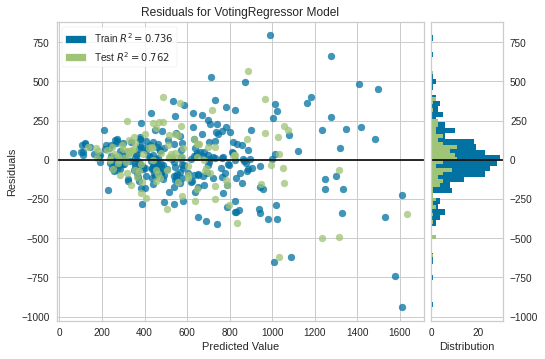

In [112]:
plot_model(final_model)

In [113]:
pred_a = predict_model(final_model, data=test_apt_only)
pred_a.head()

,총세대수,단지내주차면수,공급유형_공공임대,30대(여자),30대(남자),단지당자동차보유수,Label
C1072,754,683.0,0.0,0.072331,0.068704,671.582836,660.539645
C1128,1354,1216.0,0.0,0.072331,0.068704,1205.998886,1092.239406
C1456,619,547.0,0.0,0.047049,0.048866,460.180210,470.349372
C1840,593,543.0,0.0,0.052027,0.046596,518.620197,491.109240
C1332,1297,1112.0,0.0,0.072331,0.068704,1155.229361,1012.935653


In [119]:
pred_a = pred_a[['Label']].copy()
pred_s = pred_s[['Label']].copy()

## 코드 제출

In [120]:
submission = pd.read_csv(path+ "/sample_submission.csv")

In [121]:
submission['num'] = submission['num'].astype('float')

In [122]:
for i in range(len(submission)):
  for _ in range(len(pred_s)):
    if submission['code'][i] == pred_s.index[_]:
      submission['num'][i] = pred_s['Label'][_]
  for _ in range(len(pred_a)):
    if submission['code'][i] == pred_a.index[_]:
      submission['num'][i] = pred_a['Label'][_]


In [123]:
submission

,code,num
0,C1072,660.539645
1,C1128,1092.239406
2,C1456,470.349372
3,C1840,491.109240
4,C1332,1012.935653
...,...,...
145,C2456,282.916522
146,C1266,555.813488
147,C2152,112.694510
148,C1267,465.961620


In [124]:
submission.to_csv('submit.csv', index=False,float_format='%.4f')